# Objective
* 20190102: 
    * Predict stock price in next day using long short term memory(LSTM)
    * Given prices for the last N days, we do prediction for day N+1
    * Here we split 3 years of data into train(60%), dev(20%) and test(20%)
    * Here we use MinMaxScalar to fit_transform the train set, which we then use to transform the test set

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import math
import matplotlib
from matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.metrics import mean_squared_error
from tqdm import tqdm



In [1]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

#### Input params ##################
stk_path = "payh.csv"
test_size = 0.3                # proportion of dataset to be used as test set
cv_size = 0.1                  # proportion of dataset to be used as cross-validation set

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=1                 # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=1                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(1)
set_random_seed(model_seed)

Using TensorFlow backend.


# Common functions

In [2]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def run_model(x_train_scaled, 
                    y_train_scaled, 
                    x_cv_scaled, 
                    y_cv_scaled, 
                    scaler, 
                    lstm_units=128, 
                    dropout_prob=0.8, 
                    optimizer='adam', 
                    epochs=1, 
                    batch_size=1):
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) 
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)   
    est_scaled = model.predict(x_cv_scaled)
    est = scaler.inverse_transform(est_scaled)
    y_cv = scaler.inverse_transform(y_cv_scaled)
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, pred

# Load data

In [241]:
df = pd.read_csv('bydf.csv')

In [242]:
df['date'] = df['Unnamed: 0']
df = df.drop(['Unnamed: 0'], axis=1)
df.head(1)

,open,close,high,low,volume,money,date
0,3.33,3.33,3.38,3.31,6205383.0,20728330.0,2005-01-04


In [243]:
df.loc[:, 'date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

Text(0, 0.5, 'price')

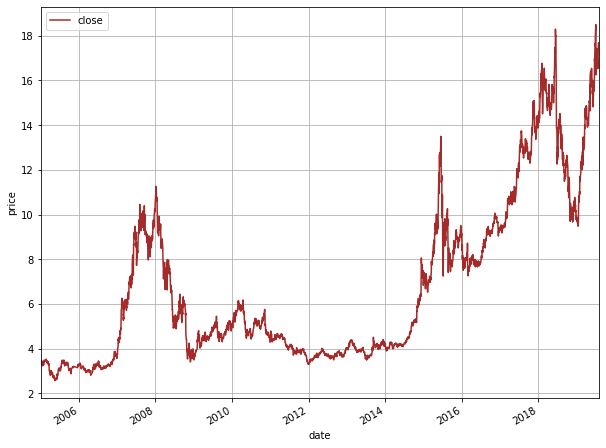

In [244]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='close', style='brown', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("price")

# Split into train, dev and test sets

We use lags up to N number of days to use as features.

In [245]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train][['date', 'close']]
cv = df[num_train:num_train+num_cv][['date', 'close']]
train_cv = df[:num_train+num_cv][['date', 'close']]
test = df[num_train+num_cv:][['date', 'close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 2099
num_cv = 349
num_test = 1048
train.shape = (2099, 2)
cv.shape = (349, 2)
train_cv.shape = (2448, 2)
test.shape = (1048, 2)


In [246]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(np.array(train['close']).reshape(-1,1))
print("scaler.data_min_ = " + str(scaler.data_min_))
print("scaler.data_max_ = " + str(scaler.data_max_))

# Split into x and y
x_train, y_train = get_x_y(train_scaled, N, N)
print("x_train.shape = " + str(x_train.shape)) # (446, 7, 1)
print("y_train.shape = " + str(y_train.shape)) # (446, 1)

# x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) # (446, 7, 1)
# print("x_train.shape = " + str(x_train.shape))

scaler.data_min_ = [2.57]
scaler.data_max_ = [11.26]
x_train.shape = (2090, 9, 1)
y_train.shape = (2090, 1)


In [247]:
# Scale the cv dataset according the min and max obtained from train set
train_cv_scaled  = scaler.transform(np.array(train_cv['close']).reshape(-1,1))

# Split into x and y
x_cv, y_cv = get_x_y(train_cv_scaled, N, num_train)
print("x_cv.shape = " + str(x_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))

x_cv.shape = (349, 9, 1)
y_cv.shape = (349, 1)


In [248]:
# Here we scale the train_cv set, for the final model
scaler_final = MinMaxScaler(feature_range=(0, 1))
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['close']).reshape(-1,1))
print("scaler_final.data_min_ = " + str(scaler_final.data_min_))
print("scaler_final.data_max_ = " + str(scaler_final.data_max_))

# Scale the test dataset according the min and max obtained from train_cv set
test_scaled  = scaler_final.transform(np.array(df['close']).reshape(-1,1))

scaler_final.data_min_ = [2.57]
scaler_final.data_max_ = [11.26]


# Create and fit the LSTM network

In [249]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/1
 - 34s - loss: 0.0016


In [250]:
# Print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 9, 50)             10400     
_________________________________________________________________
dropout_31 (Dropout)         (None, 9, 50)             0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_32 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [191]:
# Plot model and save to file
import pydot
plot_model(model, to_file='model.png')

# Predict on dev set

In [251]:
# Do prediction
est = model.predict(x_cv)
est_inv = scaler.inverse_transform(est)

# Get correct scale of y_cv
y_cv_inv = scaler.inverse_transform(y_cv)

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv_inv, est_inv))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv_inv, est_inv)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

RMSE = 0.379
MAPE = 5.863%


Text(0, 0.5, 'price')

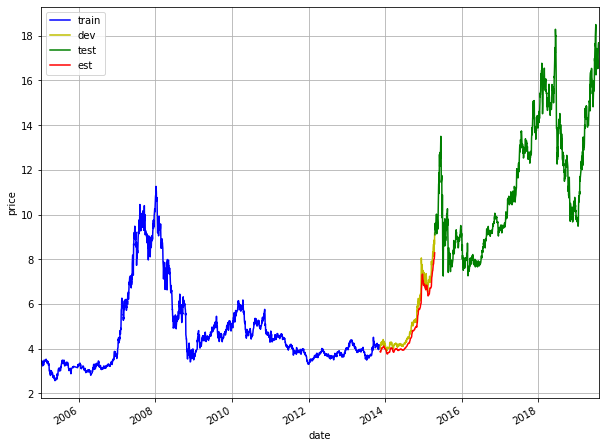

In [252]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est_inv': est_inv.reshape(-1), 
                       'y_cv_inv': y_cv_inv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est_inv', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("price")

# Tuning N (no. of days to use as features)

In [18]:
from tqdm import tqdm
param_label = 'N'
param_list = range(2, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm(param_list):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv_scaled = get_x_y(train_cv_scaled, param, num_train)
    
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv_scaled, \
                                          scaler, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer='adam', \
                                          epochs=epochs, \
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

100%|██████████| 58/58 [1:17:31<00:00, 197.33s/it]


Minutes taken = 77.51741143067677


,N,rmse,mape_pct
0,2,0.669411,7.144389
1,3,0.342095,3.760416
2,4,0.561113,5.481056
3,5,0.417673,2.811957
4,6,0.424105,4.733126
5,7,0.375832,3.591250
6,8,0.564268,7.137530
7,9,0.381971,3.668183
8,10,0.369491,3.797968
9,11,0.344963,3.544946


Text(0, 0.5, 'RMSE/MAPE(%)')

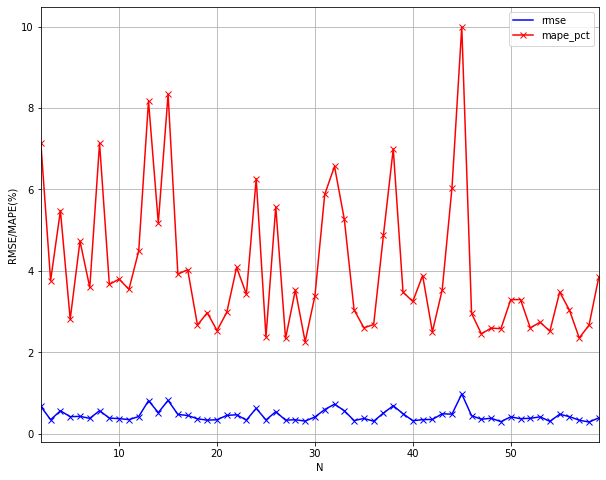

In [19]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [20]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 0.285
min MAPE = 2.260%
optimum N = 58


# Tuning model - epochs and batch_size

In [ ]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv_scaled = get_x_y(train_cv_scaled, N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm(param_list):
    
    for param2 in tqdm(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv_scaled, \
                                              scaler, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer='adam', \
                                              epochs=param, \
                                              batch_size=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

100%|██████████| 6/6 [3:53:08<00:00, 2874.56s/it]


Minutes taken = 233.14151756366093


,epochs,batch_size,rmse,mape_pct
0,1,8,0.461151,3.494894
1,1,16,0.533650,3.535818
2,1,32,0.577647,4.027868
3,1,64,0.732507,5.377708
4,1,128,1.429415,12.271872
5,10,8,0.363780,3.203462
6,10,16,0.304941,2.274035
7,10,32,0.432002,2.975166
8,10,64,0.426673,3.037539
9,10,128,0.514454,3.464733


In [142]:
# Plot performance versus params
rcParams['figure.figsize'] =8, 4 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

NameError: name 'param2_label' is not defined

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 0.208
min MAPE = 1.611%
optimum epochs = 40
optimum batch_size = 16


# Tuning model - LSTM units and dropout prob

In [ ]:
param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm(param_list):
    
    for param2 in tqdm(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv_scaled, \
                                              scaler, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer='adam', \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

  0%|          | 0/6 [00:00<?, ?it/s]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



 67%|██████▋   | 4/6 [2:04:50<1:02:28, 1874.01s/it]

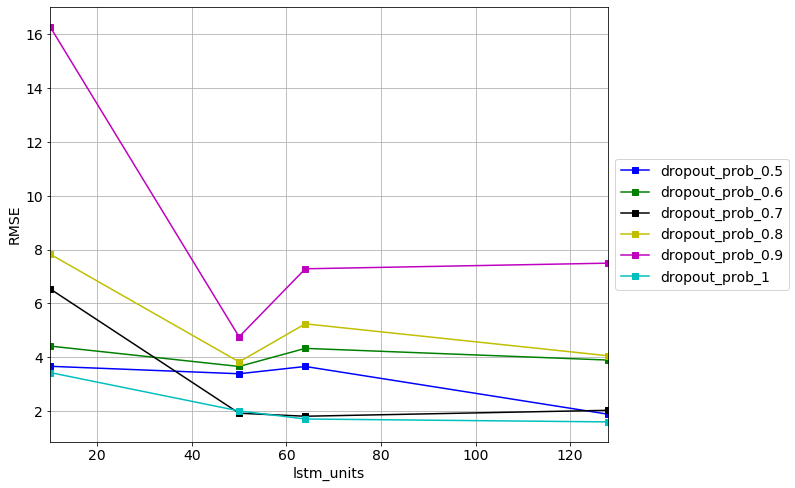

In [21]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

# Tuning model - optimizer

In [16]:
from tqdm import tqdm

In [18]:
x_train_scaled, y_train_scaled = get_x_y(train_scaled, 58, 58)

# Split cv into x and y
x_cv_scaled, y_cv_scaled = get_x_y(train_cv_scaled, 58, num_train)

In [19]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm(param_list):
   
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv_scaled, \
                                              scaler, \
                                              lstm_units=128, \
                                              dropout_prob=0.8, \
                                              optimizer=param, \
                                              epochs=40, \
                                              batch_size=16)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

  0%|          | 0/7 [00:00<?, ?it/s]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


100%|██████████| 7/7 [53:05<00:00, 499.61s/it]


Minutes taken = 53.09293480316798


,optimizer,rmse,mape_pct
0,adam,0.496156,3.744121
1,sgd,0.731105,5.198399
2,rmsprop,0.281817,2.085262
3,adagrad,0.505346,3.473510
4,adadelta,0.555899,4.327362
5,adamax,0.661213,5.743044
6,nadam,0.286749,2.201697


Text(0, 0.5, 'RMSE/MAPE(%)')

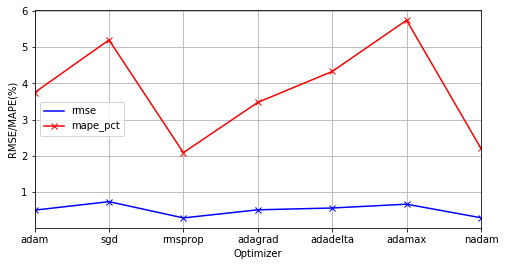

In [141]:
# Plot RMSE 
rcParams['figure.figsize'] = 8, 4 # width 10, height 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [21]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 0.282
min MAPE = 2.085%
optimum optimizer = rmsprop


# Tuned params

In [ ]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

# Final model

In [253]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, 58, 58)

# Split test into x and y
x_test_scaled, y_test_scaled = get_x_y(test_scaled, 58, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test_scaled, \
                                        scaler_final, \
                                        lstm_units=128, \
                                        dropout_prob=0.8, \
                                        optimizer='rmsprop', \
                                        epochs=40, \
                                        batch_size=16)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 0.701
MAPE on test set = 4.060%


Text(0, 0.5, 'Price')

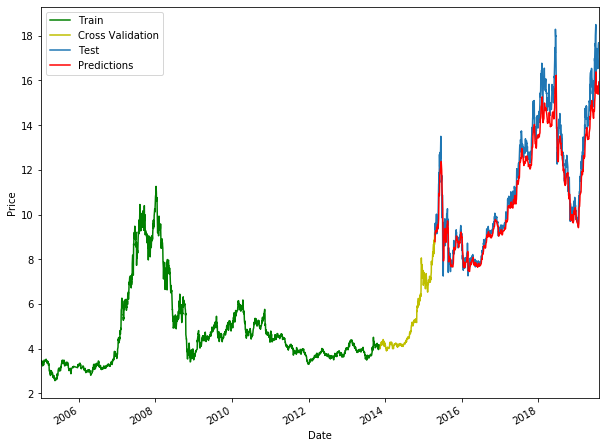

In [254]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='close', style='g-')
ax = cv.plot(x='date', y='close', style='y-', ax=ax)
ax = test.plot(x='date', y='close', style='-', ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', ax=ax)
ax.legend(['Train', 'Cross Validation', 'Test', 'Predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Price")

Text(0.5, 1.0, 'Zoom in to test set')

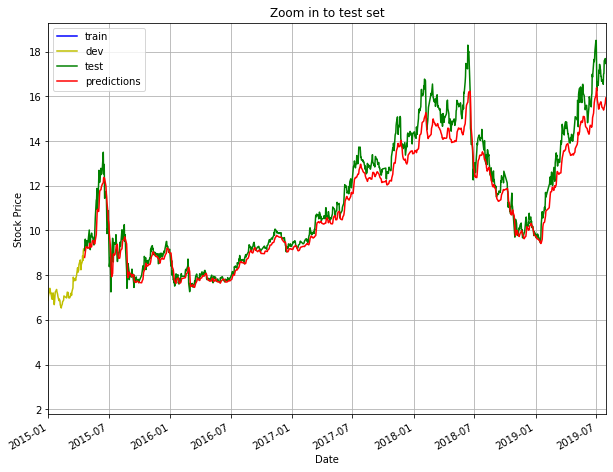

In [255]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")
ax.set_xlim([date(2015, 1, 1), date(2019, 8, 1)])
#ax.set_ylim([130, 155])
ax.set_title("Zoom in to test set")

# Findings
* On the test set, the RMSE is 2.988 and MAPE is 1.886% using N_opt=5

In [256]:
est_df.head(5)

,est,date
2448,8.791654,2015-04-20
2449,8.879524,2015-04-21
2450,9.012122,2015-04-22
2451,9.162843,2015-04-23
2452,9.255055,2015-04-24


In [263]:
comp_payh = df.iloc[2477:,::]

In [264]:
comp_payh.head(2)

,open,close,high,low,volume,money,date
2477,11.04,12.10,12.10,10.99,40952721.0,476503104.0,2015-06-01
2478,12.10,12.69,12.88,11.89,61623356.0,761632256.0,2015-06-02


In [265]:
comp_payh['est'] = est_df['est']
comp_payh.head(2)

C:\Users\ZSZ\Anaconda3\envs\ForDL\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,open,close,high,low,volume,money,date,est
2477,11.04,12.10,12.10,10.99,40952721.0,476503104.0,2015-06-01,10.848499
2478,12.10,12.69,12.88,11.89,61623356.0,761632256.0,2015-06-02,11.009812


In [279]:
comp_payh.tail(1)

,open,close,high,low,volume,money,date,est
3495,17.55,17.62,17.65,17.28,9674510.0,169331634.0,2019-08-01,15.944185


In [274]:
profit = 0
profit_cum = []
profit_date = []
return_cum = []
return_rate = 0
holding_stock = False

for i in range(1, len(comp_payh['close'].values)):
    if holding_stock == False:
        if comp_payh['est'].values[i-1] >= comp_payh['close'].values[i-1]:
            pass
        else:
            buy = comp_payh['open'].values[i]
            holding_stock = not holding_stock
    else:
        if comp_payh['est'].values[i-1] < comp_payh['close'].values[i-1]:
            pass
        else:
            sell = comp_payh['open'].values[i]
            holding_stock = not holding_stock
            profit = profit + sell - buy
            return_rate = profit / comp_payh['close'].values[0]
    profit_cum.append(profit)
    return_cum.append(return_rate)
    profit_date.append(comp_payh['date'].values[i])
    
    
print(profit)

2.299999999999997


In [271]:
profit = 0
profit_cum = []
profit_date = []
return_cum = []
return_rate = 0
holding_stock = False

for i in range(1, len(comp_payh['close'].values)):
    if holding_stock == False:
        if comp_payh['est'].values[i-1] >= comp_payh['close'].values[i-1]:
            buy = comp_payh['open'].values[i]
            holding_stock = not holding_stock
        else:
            pass
    else:
        if comp_payh['est'].values[i-1] < comp_payh['close'].values[i-1]:
            sell = comp_payh['open'].values[i]
            holding_stock = not holding_stock
            profit = profit + sell - buy
            return_rate = profit / comp_payh['close'].values[0]
        else:
            pass
    profit_cum.append(profit)
    return_cum.append(return_rate)
    profit_date.append(comp_payh['date'].values[i])
    
    
print(profit)

2.4300000000000033


In [267]:
3 / comp_payh['close'].values[0]

0.24793388429752067

In [268]:
print(len(profit_date))

1018


In [269]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

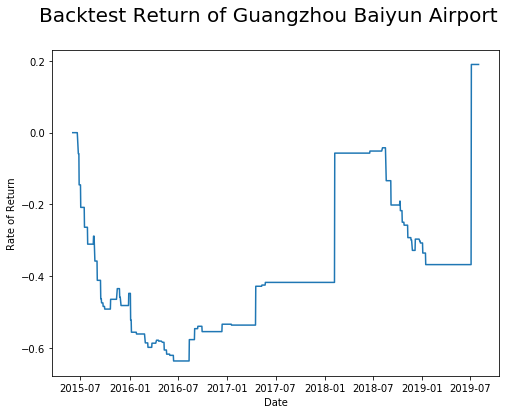

In [277]:
#ax = plt.gca()   #表明设置图片的各个轴，plt.gcf()表示图片本身

fig = plt.figure(figsize=(8,6))
#ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))  # 横坐标标签显示的日期格式

fig.suptitle('Backtest Return of Guangzhou Baiyun Airport', fontsize=20)
plt.plot(profit_date,return_cum) #横坐标日期范围及间隔
#plt.plot(csidate,csi_return)
plt.xlabel('Date')
plt.ylabel('Rate of Return')
plt.show()

In [278]:
return_cum[-1]

0.19008264462809896

In [132]:
csi = pd.read_csv('csi.csv')

In [133]:
csi.head(1)

,Unnamed: 0,open,close,high,low,volume,money
0,2012-05-28,2.243,2.318,2.318,2.243,457580493.0,1.037835e+09


In [134]:
csi['date'] =csi['Unnamed: 0']
csi = csi.drop(['Unnamed: 0'], axis=1)
csi.loc[:, 'date'] = pd.to_datetime(csi['date'],format='%Y-%m-%d')
csi.head(1)

,open,close,high,low,volume,money,date
0,2.243,2.318,2.318,2.243,457580493.0,1.037835e+09,2012-05-28


In [135]:
comp_csi = csi.iloc[731:,::]

In [136]:
comp_csi.head(1)

,open,close,high,low,volume,money,date
731,4.785,4.851,4.858,4.722,219431215.0,1.046923e+09,2015-06-02


In [137]:
csiprice = comp_csi['close'].values.tolist()
csidate = comp_csi['date'].values.tolist()
csi_return = [(i-4.851)/4.851 for i in csiprice]


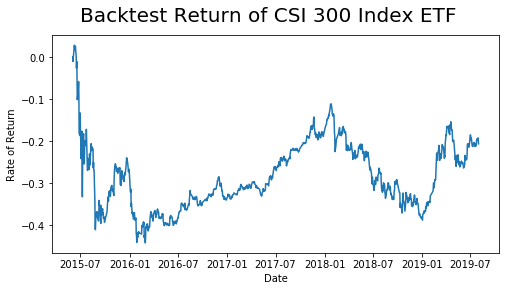

In [140]:
fig = plt.figure(figsize=(8,4))
#ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))  # 横坐标标签显示的日期格式
fig.suptitle('Backtest Return of CSI 300 Index ETF', fontsize=20)
#fig.suptitle('Backtest Return of Ping An Bank', fontsize=20)
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
#plt.plot(profit_date,return_cum)
plt.plot(comp_csi['date'],csi_return) #横坐标日期范围及间隔
plt.xlabel('Date')
plt.ylabel('Rate of Return')
plt.show()

In [143]:
csi_return[-1]

-0.20676149247577813